In [ ]:
#hide
#colab
# attach gdrive holding repo
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#default_exp multi_core.lr_find

# Multi Core LR Find XLA Extensions

> Classes to replace LRFinder and patches to Learner
to support running lr_find using multi core TPUs

Modifications to existing callback `LRFinder` are needed in order to run `lr_find` using multiple TPU cores. An equivalent `xla_lr_find` method is patched to `Learner` so it can run on multiple TPU cores.

In [ ]:
#hide
#colab
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 133.6MB 77kB/s 
     |████████████████████████████████| 61kB 2.5MB/s 


In [ ]:
#hide
#colab
# !pip install -Uqq git+https://github.com/fastai/fastai.git 
!pip install -Uqq fastai --upgrade

     |████████████████████████████████| 194kB 6.3MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 


In [ ]:
#hide
#colab
!pip install -qqq nbdev

     |████████████████████████████████| 51kB 3.0MB/s 


In [ ]:
#hide
#colab
# !pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions.git

In [ ]:
#hide
#colab
# !pip install -Uqq git+https://github.com/butchland/my_timesaver_utils.git

In [ ]:
#hide
#colab
!curl -s https://course19.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
#hide
#colab
%cd /content
!ln -s /content/drive/MyDrive/fastai_xla_extensions  fastai_xla_extensions

/content


In [ ]:
#hide
!pip freeze | grep torch
!pip freeze | grep fast
!pip freeze | grep timesaver
!pip freeze | grep nbdev

torch==1.7.0+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101
fastai==2.2.7
fastcore==1.3.19
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5
nbdev==1.1.12


In [ ]:
# hide
# start of kernel

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
# colab
%cd /content/fastai_xla_extensions

/content/drive/MyDrive/fastai_xla_extensions


In [ ]:
#exporti
from fastai_xla_extensions.utils import xla_imported
from fastai_xla_extensions.misc_utils import *
from fastai_xla_extensions.multi_core.base import *
from fastai_xla_extensions.multi_core.learner import *
from fastai_xla_extensions.multi_core.callback import *

In [ ]:
#hide
#colab
%cd /content

/content


In [ ]:
#exporti
try:
    import torch_xla
except:
    pass

In [ ]:
#exporti
if xla_imported():
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp

In [ ]:
#hide
#local
# fake out torch_xla modules if not running on xla supported envs
if not xla_imported():
    # replace torch xla modules with fake equivalents
    from types import SimpleNamespace
    torch_xla = SimpleNamespace (
    )
    from typing import Union,BinaryIO
    import os
    import pickle
    import torch.cuda

    def fake_opt_step(opt,barrier=False):
        opt.step()
        
    def fake_device(n=None, devkind=None):
        gpu_available = torch.cuda.is_available()
        if gpu_available:
            return torch.device(torch.cuda.current_device()) 
        return torch.device('cpu')

    def fake_save(obj, f: Union[str, os.PathLike, BinaryIO], 
                master_only=True, global_master=False): 
        return torch.save(obj,f,pickle_module=pickle, 
                        pickle_protocol=2, 
                        _use_new_zipfile_serialization=True)
    def fake_rate():
        return 230.20

    def fake_global_rate():
        return 830.10

    def fake_add(*args,**kwargs):
        pass

    def fake_RateTracker():
        return SimpleNamespace(
            rate = fake_rate,
            global_rate = fake_global_rate,
            add = fake_add
        )
    def fake_xrt_world_size():
        return 1
    def fake_get_ordinal():
        return 0
    xm = SimpleNamespace(
        optimizer_step = fake_opt_step,
        xla_device = fake_device,
        save = fake_save,
        RateTracker = fake_RateTracker,
        master_print = print,
        xrt_world_size = fake_xrt_world_size,
        get_ordinal = fake_get_ordinal
    )

    def fake_metrics_report():
        return "Fake Metrics Report \n\n\n\n"
    met = SimpleNamespace (
        metrics_report = fake_metrics_report
    )

    class FakeParallelLoader:
        def __init__(self, loader, *args):
            self.loader = loader
        def per_device_loader(self,device):
            return self.loader
        
    pl = SimpleNamespace(
        ParallelLoader = FakeParallelLoader
    )

    def fake_MpModelWrapper(o):
        return o

    def fake_run(f,*args, **kwargs):
            return f(*args,**kwargs)
        
    def fake_MpSerialExecutor():
        return SimpleNamespace(
            run = fake_run
        )
    def fake_spawn(f, args=None, nprocs=0, start_method=None):
        return f(0,*args)

    xmp = SimpleNamespace (
        MpModelWrapper = fake_MpModelWrapper,
        MpSerialExecutor = fake_MpSerialExecutor,
        spawn = fake_spawn
    )

    xu = SimpleNamespace (
    )


In [ ]:
#exporti
# from fastai.vision.all import *
# from fastai_xla_extensions.all import *


In [ ]:
#export
from fastai.callback.core import Callback
from fastai.learner import CancelValidException

class SkipValidationCallback(Callback):
    order,run_valid = -9, False
    # raise CancelValidException before XLATrainingCallback.before_validate
    # to prevent call to wrap_parallel_loader on before_validate
    def before_validate(self): 
        raise CancelValidException()

    def after_cancel_validate(self):
        xm.mark_step()


In [ ]:
#export
from fastai.callback.schedule import ParamScheduler, SchedExp

class XLALRFinder(ParamScheduler):
    "Training with exponentially growing learning rate"
    def __init__(self, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True):
        if is_listy(start_lr):
            self.scheds = {'lr': [SchedExp(s, e) for (s,e) in zip(start_lr,end_lr)]}
        else: self.scheds = {'lr': SchedExp(start_lr, end_lr)}
        self.num_it,self.stop_div = num_it,stop_div
        self.skip_batch = False
        self.num_losses = 0

    def before_fit(self):
        super().before_fit()
        # no need to save orig weights 
        # since learner instances are transient on spawned procs
        # self.learn.save('_tmp')
        self.best_loss = float('inf')
        self.skip_batch = False
        self.num_losses = 0
        # dont report losses while running lrfind (override sync_recorder)
        # run after sync_recorder.before_fit (sync_recorder.order == 55)
        # while param scheduler order == 60
        if xm.is_master_ordinal() and hasattr(self.learn, 'sync_recorder'):
            self.learn.logger = noop
            self.learn.sync_recorder._sync_stats_log = noop


    def before_batch(self):
        if self.skip_batch:
            return
        self._update_val(self.train_iter/self.num_it)

    def after_batch(self):
        if self.skip_batch:
            return
        super().after_batch()
        smooth_loss = self.smooth_loss.item() # move xla tensor to cpu
        self.num_loss = len(self.recorder.losses)
        if smooth_loss < self.best_loss:
            self.best_loss = smooth_loss

        # handle continuation of batch iteration until all batches exhausted
        if smooth_loss > 4*self.best_loss and self.stop_div:
            self.skip_batch = True
            return
            
        if self.train_iter >= self.num_it:
            self.skip_batch = True
            return

    def after_fit(self):
        # no need to load old weights since these will be transient
        # self.learn.opt.zero_grad() 
        # Need to zero the gradients of the model before detaching the optimizer for future fits
        # tmp_f = self.path/self.model_dir/'_tmp.pth'
        # if tmp_f.exists():
        #     self.learn.load('_tmp', with_opt=True)
        #     os.remove(tmp_f)
        if not xm.is_master_ordinal(): return

        if not self.skip_batch: # completed w/o copying lrs and losses from recorder to plot_data
            self.num_loss = len(self.recorder.losses)

        self.recorder.losses = self.recorder.losses[: self.num_loss]
        self.recorder.lrs = self.recorder.lrs[: self.num_loss]
        num_iters = len(self.recorder.iters)
        for i, iter in enumerate(self.recorder.iters):
            if iter >= self.num_it:
                num_iters = i + 1
                break
        self.recorder.iters = self.recorder.iters[:num_iters]
        self.recorder.values = self.recorder.values[:num_iters]
        self.recorder.dump_attrs() # rewrite updated attrs



In [ ]:
#export

def xla_run_lr_find(rank, learner_args, add_args, lr_find_args, ctrl_args):
    'run xla lr_find on spawned processes'
    xm.rendezvous('start_run_lrfind')
    # print(f'xla {rank} : start run lrfind')
    sync_valid = True
    learner = make_xla_child_learner(rank, sync_valid, learner_args, add_args, ctrl_args)
    num_it = lr_find_args['num_it']
    n_epoch = num_it//len(learner.dls.train) + 1
    lr_find_cb = XLALRFinder(**lr_find_args)

    skip_valid_cb = SkipValidationCallback()
    
    with learner.no_logging(): 
        learner.fit(n_epoch, cbs=[lr_find_cb, skip_valid_cb])
    


In [ ]:
#export
from fastai.learner import Learner
from fastai.callback.schedule import SuggestedLRs
from fastai.basics import patch
from fastai.torch_core import tensor
@patch
def get_suggested_lrs(self:Learner, num_it):
    'compute Suggested LRs'
    lrs,losses = tensor(self.recorder.lrs[num_it//10:-5]),tensor(self.recorder.losses[num_it//10:-5])
    if len(losses) == 0: return
    lr_min = lrs[losses.argmin()].item()
    grads = (losses[1:]-losses[:-1]) / (lrs[1:].log()-lrs[:-1].log())
    lr_steep = lrs[grads.argmin()].item()
    return SuggestedLRs(lr_min/10.,lr_steep)


In [ ]:
#hide_input
show_doc(Learner.get_suggested_lrs)

In [ ]:
#export
from fastai.learner import Learner
from fastcore.basics import patch
from fastcore.meta import delegates
from fastcore.foundation import L
from fastai.callback.progress import ProgressCallback
@patch
@delegates(Learner.lr_find, but='num_cores,start_method')
def xla_lr_find(self:Learner, num_cores=8, start_method='fork', **kwargs):
    'multi core xla equivalent of `lr_find`'
    # default params for lr_find
    lr_find_args = {
        'start_lr': 1e-7,
        'end_lr': 10.,
        'num_it': 100,
        'stop_div': True
    }
    has_progress = 'progress' in L(self.cbs).attrgot('name')
    show_plot = True
    suggestions = True

    # remove show_plot and suggestions param
    if 'show_plot' in kwargs:
        show_plot = kwargs.pop('show_plot')
    if 'suggestions' in kwargs:
        suggestions = kwargs.pop('suggestions')
    # override default with kwargs
    lr_find_args = {**lr_find_args, **kwargs}    

    ctrl_args = self.pre_xla_fit()
    learner_args, add_args = self.pack_learner_args()
    xmp.spawn(xla_run_lr_find,
              args=(learner_args, add_args, lr_find_args, ctrl_args),
              nprocs=num_cores,
              start_method=start_method)
    
    self.recorder.reload_attrs()
    self.recorder.reload_hps()
    if has_progress and 'progress' not in L(self.cbs).attrgot('name'):
        self.add_cbs([ProgressCallback])
    if show_plot:
        self.recorder.plot_lr_find()
    if suggestions:
        return self.get_suggested_lrs(lr_find_args['num_it'])

## Test out routines

In [ ]:
#colab
from fastai.vision.all import *
# path = untar_data(URLs.MNIST_TINY)
path = untar_data(URLs.MNIST)

In [ ]:
#colab
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
    # splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [ ]:
#colab
dls = data.dataloaders(path, bs=64)

In [ ]:
#colab
learner = cnn_learner(dls, resnet18, metrics=accuracy, concat_pool=False)

start fit


SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.02754228748381138)

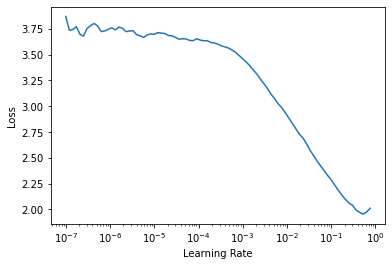

In [ ]:
#colab
# %%time
# learner.xla_lr_find(stop_div=True,end_lr=100, num_it=400)
learner.xla_lr_find()

In [ ]:
#colab
learner.xla_fit_one_cycle(5, lr_max=slice(0.026))

start fit


epoch,train_loss,valid_loss,accuracy,time
0,0.706360,6.423634,0.212500,02:07
1,0.278304,4.497978,0.186800,02:06
2,0.155366,4.614498,0.164200,02:06
3,0.105571,5.019136,0.131900,02:17
4,0.092460,5.037888,0.131600,02:08
